In [ ]:
!pip install mne

     |████████████████████████████████| 7.4 MB 16.8 MB/s 


In [ ]:
#import packages

from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, AveragePooling2D, Dense, Flatten, Activation, Dropout, Input, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import metrics
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import backend as K
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit
import os
import numpy as np
import pandas as pd
import pickle
import mne
import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Format Data

### Get data from fif files

In [ ]:
filepath = '/content/drive/MyDrive/unfiltered-semiclean/'

In [ ]:
files = [f for f in os.listdir(filepath) if f.endswith('.fif')]

In [ ]:
AD = []
Control=[]
for f in files:
    eps = mne.read_epochs(filepath+f)
    if f.startswith('AD'):
        AD.append(eps)
    else:
        eps = mne.epochs.combine_event_ids(eps, ['1'], 0)
        Control.append(eps)

### Concatenate the epochs

In [ ]:
epochs_AD = mne.concatenate_epochs(AD)
epochs_control = mne.concatenate_epochs(Control)
epochs_total = mne.concatenate_epochs([epochs_AD, epochs_control])

summary of epochs and events

Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


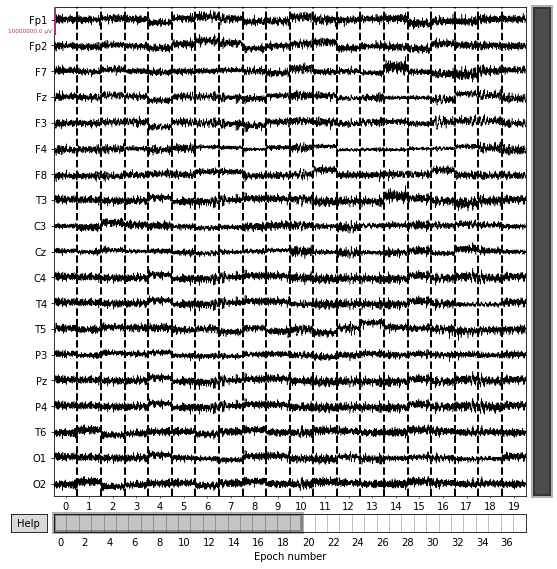

In [ ]:
eps.plot(scalings=5).savefig('epochs.png', dpi=1200)

In [ ]:
epochs_total

Number of events,14111
Events,0: 43181: 9793
Time range,0.000 – 2.000 sec
Baseline,off


### Set up data for CNN

In [ ]:
X = epochs_total.get_data()


A_labels = tf.keras.utils.to_categorical(epochs_AD.events[:, 2], 2)
c_labels = tf.keras.utils.to_categorical(epochs_control.events[:, 2], 2)
y = np.vstack((A_labels, c_labels))

In [ ]:
X.shape # shape of X

(14111, 19, 257)

Split data into train and test

In [ ]:
X = np.expand_dims(X, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.75, random_state=0, shuffle=True)
val = round(.25 * X_train.shape[0])
shuffle_split = ShuffleSplit(n_splits=30, test_size=val, random_state=0)


In [ ]:
X_train.shape # shape of X

(3527, 19, 257, 1)

## Define CNN model

In [ ]:
def cnn_model(channels = 19, time_samples = X.shape[2]):

    classifier = Sequential()
    classifier.add(Conv2D(6, (3, 3), activation='elu', input_shape=(channels, time_samples, 1)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))
    classifier.add(AveragePooling2D(pool_size=(1, 8)))
    classifier.add(Flatten())
    classifier.add(Dense(100, activation='elu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))
    classifier.add(Dense(2, activation='softmax', name='visualized_layer'))

    classifier.compile(loss='binary_crossentropy', optimizer='adam',
                        metrics=['binary_accuracy', keras.metrics.AUC()])
    return classifier

## Run CNN on the full dataset

In [ ]:
model = cnn_model(X_train.shape[1], X_train.shape[2])
hist = model.fit(X_train, y_train, epochs=30, batch_size=16, shuffle=True, verbose=2, validation_data=(X_test, y_test))

In [ ]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://7b7ebb2d-eb9b-439a-8326-0bd4f45bcd91/assets


In [ ]:
#make confusion matrix from tensorflow
y_pred = model.predict(X_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x,y in y_test], axis=0)
cm = tf.math.confusion_matrix(predicted_categories, true_categories)
precision = cm[1,1]/(cm[1,1]+cm[0,1]) # precision = TP/(TP+FP)
recall = cm[1,1]/(cm[1,1]+cm[1,0]) # recall = TP/(TP+FN)

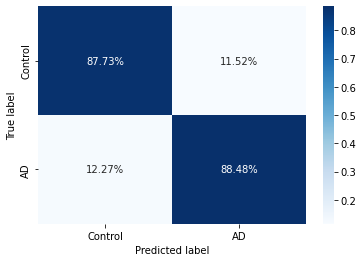

In [ ]:
df = pd.DataFrame(cm.numpy())
fig = sns.heatmap(df/np.sum(df), annot=True, 
            fmt='.2%', cmap='Blues')
#add x and y labels
fig.set_xlabel('Predicted label')
fig.set_ylabel('True label')
#add x and y ticks
fig.set_xticklabels(['Control', 'AD'])
fig.set_yticklabels(['Control', 'AD'])
#save figure
fig.get_figure().savefig('confusion_matrix.png')

### Evaluate model

Text(0.5, 1.0, 'model auc')

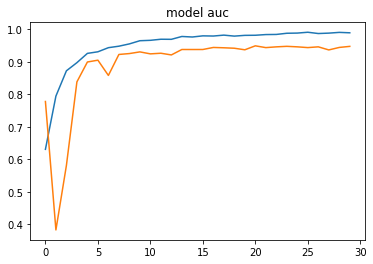

In [ ]:
#plot roc curve
import matplotlib.pyplot as plt
plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
plt.title('model auc')

Text(0.5, 1.0, 'model recall')

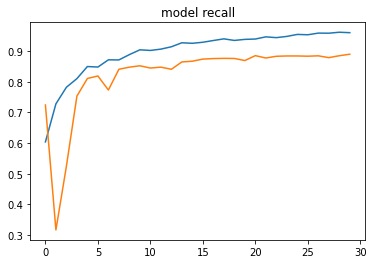

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('model recall')

Text(0.5, 1.0, 'model loss')

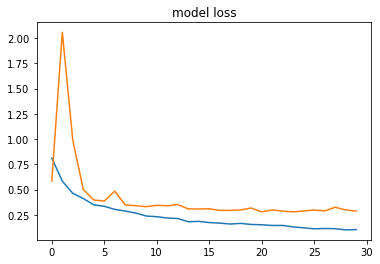

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')

In [ ]:
hist.history['auc'][-1]

0.9897342920303345

In [ ]:
hist.history['loss'][-1]

0.10312435775995255

In [ ]:
hist.history['val_loss'][-1]

0.2872377634048462

In [ ]:
hist.history['val_auc'][-1]

0.947892427444458

In [ ]:
hist.history['val_binary_accuracy'][-1]

0.8899299502372742

## Run cross validation

In [ ]:
def c_m(X_test, y_test, model):
    y_pred = model.predict(X_test)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x,y in y_test], axis=0)
    cm = tf.math.confusion_matrix(predicted_categories, true_categories)
    precision = cm[1,1]/(cm[1,1]+cm[0,1]) # precision = TP/(TP+FP)
    recall = cm[1,1]/(cm[1,1]+cm[1,0]) # recall = TP/(TP+FN)
    return cm, precision.numpy(), recall.numpy()

In [ ]:
train_results = []
val_results = []
test_results = []
cmdf_v =[]
cmdf_test =[]
for train, validation in shuffle_split.split(X_train):
    model = cnn_model(X_train[train].shape[1], X_train[train].shape[2])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    hist = model.fit(X_train[train], y_train[train], epochs=30, batch_size=16, shuffle=True, callbacks=[early_stopping], verbose=2, validation_data=(X_train[validation], y_train[validation]))
    keys = list(hist.history.keys())
    cm, precision, recall = c_m(X_train[validation], y_train[validation], model)
    cmdf_v.append(cm)
    val_metrics = [hist.history[keys[3]][-1], hist.history[keys[4]][-1], hist.history[keys[5]][-1], precision, recall]
    val_results.append(val_metrics)
    train_metrics = [hist.history[keys[0]][-1], hist.history[keys[1]][-1], hist.history[keys[2]][-1], precision, recall]
    train_results.append(train_metrics)
    cm, precision, recall = c_m(X_test, y_test, model)
    cmdf_test.append(cm)
    mets = [model.evaluate(X_test, y_test, verbose=2), precision, recall]

    test_metrics = mets
    test_results.append(test_metrics)

### Evaluate the model

In [ ]:
avg_val_results = np.round(np.mean(val_results, axis=0) * 100, 2)
avg_val_results_std = np.round(np.std(val_results, axis=0) * 100, 2)

print("Averaged validation results(std):")
print("loss: ", avg_val_results[0], "(", avg_val_results_std[0], ")")
print("accuracy: ", avg_val_results[1], "(", avg_val_results_std[1], ")")
print("auc: ", avg_val_results[2], "(", avg_val_results_std[2], ")")
print("precision: ", avg_val_results[3], "(", avg_val_results_std[3], ")")
print("recall: ", avg_val_results[4], "(", avg_val_results_std[4], ")")

print("\n##############################\n")

avg_test_results = np.round(np.mean(test_results2, axis=0) * 100, 2)
avg_test_results_std = np.round(np.std(test_results2, axis=0) * 100, 2)

print("Averaged test results(std)): ")
print("loss: ", avg_test_results[0], "(", avg_test_results_std[0], ")")
print("accuracy: ", avg_test_results[1], "(", avg_test_results_std[1], ")")
print("auc: ", avg_val_results[2], "(", avg_val_results_std[2], ")")
print("precision: ", avg_test_results[3], "(", avg_test_results_std[3], ")")
print("recall: ", avg_test_results[4], "(", avg_test_results_std[4], ")")

Averaged validation results(std):
loss:  33.72 ( 5.26 )
accuracy:  86.07 ( 2.53 )
auc:  92.88 ( 2.05 )
precision:  89.49 ( 5.53 )
recall:  90.75 ( 2.11 )

##############################

Averaged test results(std)): 
loss:  33.86 ( 3.68 )
accuracy:  86.1 ( 1.87 )
auc:  92.88 ( 2.05 )
precision:  89.98 ( 4.83 )
recall:  90.11 ( 2.3 )


In [ ]:
val_losses = [x[0] for x in val_results]
test_losses = [x[0] for x in test_results2]
val_accs = [x[1] for x in val_results]
test_accs = [x[1] for x in test_results2]
train_losses = [x[0] for x in train_results]
train_accs = [x[1] for x in train_results]

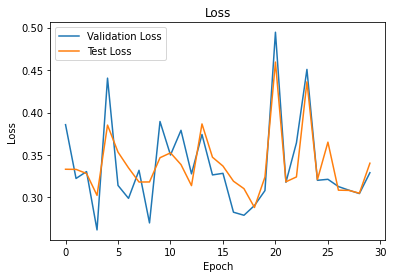

In [ ]:
#compare test and validation loss
plt.figure()
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

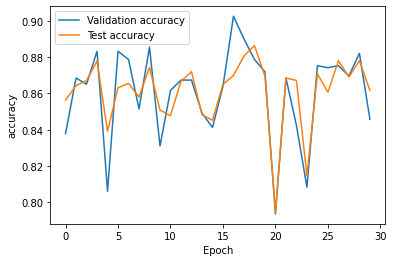

In [ ]:
#compare test and validation accuracy
plt.figure()
plt.plot(val_accs, label='Validation accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

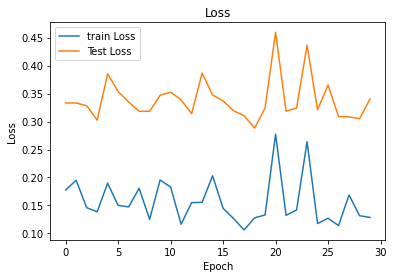

In [ ]:
#compare train and test loss
plt.figure()
plt.plot(train_losses, label='train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
#compare train and test accuracy
plt.figure()
plt.plot(train_accs, label='train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#make confusion matrix from tensorflow
y_pred = model.predict(X_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x,y in y_test], axis=0)
cm = tf.math.confusion_matrix(predicted_categories, true_categories)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
recall = cm[1,1]/(cm[1,1]+cm[1,0])
print("Precision: ", precision)
print("Recall: ", recall) 

Precision:  tf.Tensor(0.8084641638225256, shape=(), dtype=float64)
Recall:  tf.Tensor(0.9389567147613762, shape=(), dtype=float64)


In [ ]:
#average confusion matrix for each cross validation

FP=[] # i[0][1]
FN=[] # i[1][0]
TP=[] # i[1][1]
TN=[] # i[0][0]
for i in cmdf_test:
  FP.append((i[0][1]/(i[0][1] + i[1][1])) * 100)
  FN.append((i[1][0]/(i[1][0] + i[0][0])) * 100)
  TP.append((i[1][1]/(i[0][1] + i[1][1])) * 100)
  TN.append((i[0][0]/(i[0][0] + i[1][0])) * 100)

FPm = np.mean(FP)
TPm = np.mean(TP)
FNm = np.mean(FN)
TNm = np.mean(TN)
array = np.array([TNm, FNm])
array2 = np.array([FPm, TPm])
dft = pd.DataFrame()
dft[0] = array
dft[1] = array2

In [ ]:
dft

,0,1
0,77.390815,10.020933
1,22.609185,89.979067


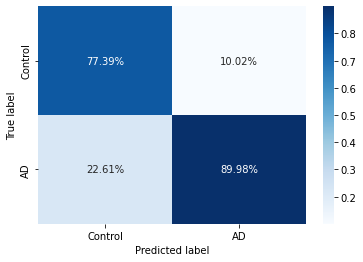

In [ ]:
fig = sns.heatmap(dft/np.sum(dft), annot=True, 
            fmt='.2%', cmap='Blues')
#add x and y labels
fig.set_xlabel('Predicted label')
fig.set_ylabel('True label')
#add x and y ticks
fig.set_xticklabels(['Control', 'AD'])
fig.set_yticklabels(['Control', 'AD'])
#save figure
fig.get_figure().savefig('confusion_matrix.png', dpi =1200)